# Sample Trained Model Usage


In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from model.consts import FLOAT_T
from model.load import load_images
from model.model import KeypointModel


## Load test data


In [2]:
data_path = Path("data") / "prashantarorat" / "facial-key-point-data"
labels_path = data_path / "all_data.json"
images_path = data_path / "images"

print(images_path)

data/prashantarorat/facial-key-point-data/images


In [3]:
test_images = images_path.glob("04*.png")

In [4]:
with open(labels_path, "rb") as f:
    labels = json.load(f)

labels_by_filename = {v["file_name"]: v for k, v in labels.items()}

labels_by_filename["04999.png"]["face_landmarks"][:5]


[[64.65979381443299, 271.83505154639175],
 [66.4192439862543, 312.3024054982818],
 [68.1786941580756, 358.0481099656357],
 [82.25429553264605, 396.7560137457045],
 [112.16494845360825, 430.1855670103093]]

In [5]:
test_filenames = sorted(labels_by_filename.keys())

In [6]:
test_ims = load_images(
    [images_path / str(filename) for filename in test_filenames],
)
test_ims.shape

100%|██████████| 5000/5000 [00:27<00:00, 182.41it/s]


(5000, 224, 224, 3)

In [7]:
test_filename_to_keypoints = {
    filename: np.array(label["face_landmarks"], dtype=FLOAT_T).T
    for filename, label in labels_by_filename.items()
}
test_keypoints = np.array(
    [test_filename_to_keypoints[filename] for filename in test_filenames]
)
test_keypoints.shape

(5000, 2, 68)

## Load trained model


In [8]:
mdl = KeypointModel("./best_model.keras")

In [9]:
pred = mdl.predict(test_ims, show=False)
pred.shape

I0000 00:00:1746895343.455917 112163463 service.cc:146] XLA service 0x32e154590 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746895343.455946 112163463 service.cc:154]   StreamExecutor device (0): Host, Default Version
2025-05-10 12:42:23.487812: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746895343.763163 112163463 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(5000, 2, 68)

In [15]:
# Difference between the predicted and actual keypoints in terms of im width
diff = (pred - test_keypoints) / test_ims.shape[1]
diff.shape

(5000, 2, 68)

## RMSE


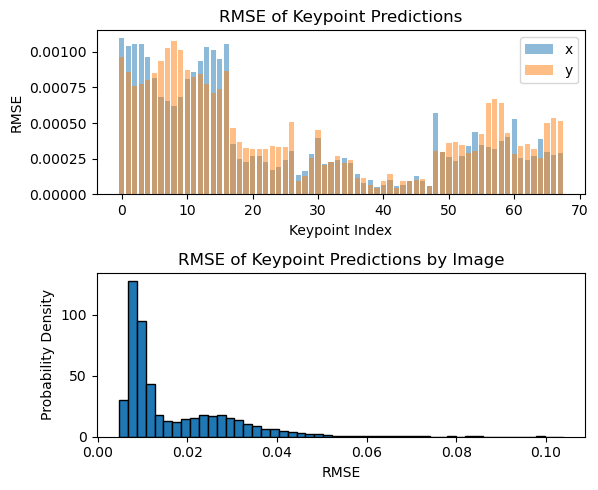

Images with highest error (RMSE): ['04473.png', '04399.png', '04371.png', '03511.png', '04708.png']
RMSE values: [0.1037144  0.09855982 0.0983022  0.0850971  0.08403462]

Images with lowest error (RMSE): ['01255.png', '02742.png', '01356.png', '01566.png', '02683.png']
RMSE values: [0.0048076  0.00486269 0.00487031 0.00503508 0.00506252]

Correlation between x and y errors: -0.1548


In [23]:
rmse_by_keypoint = np.mean(diff**2, axis=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))

ax1.bar(range(rmse_by_keypoint.shape[1]), rmse_by_keypoint[0], label="x", alpha=0.5)
ax1.bar(range(rmse_by_keypoint.shape[1]), rmse_by_keypoint[1], label="y", alpha=0.5)
ax1.set_title("RMSE of Keypoint Predictions")
ax1.set_xlabel("Keypoint Index")
ax1.set_ylabel("RMSE")
ax1.legend()

rmse_by_im = np.sqrt(np.mean(diff**2, axis=(1, 2)))

ax2.hist(rmse_by_im, bins=50, edgecolor="black", density=True)
ax2.set_title("RMSE of Keypoint Predictions by Image")
ax2.set_xlabel("RMSE")
ax2.set_ylabel("Probability Density")

plt.tight_layout()
plt.show()

worst_indices = np.argsort(-rmse_by_im)[:5]
best_indices = np.argsort(rmse_by_im)[:5]

print(f"Images with highest error (RMSE): {[test_filenames[i] for i in worst_indices]}")
print(f"RMSE values: {rmse_by_im[worst_indices]}")
print(f"\nImages with lowest error (RMSE): {[test_filenames[i] for i in best_indices]}")
print(f"RMSE values: {rmse_by_im[best_indices]}")

x_errors = np.abs(diff[0])
y_errors = np.abs(diff[1])
correlation = np.corrcoef(x_errors.flatten(), y_errors.flatten())[0, 1]
print(f"\nCorrelation between x and y errors: {correlation:.4f}")

## MSE


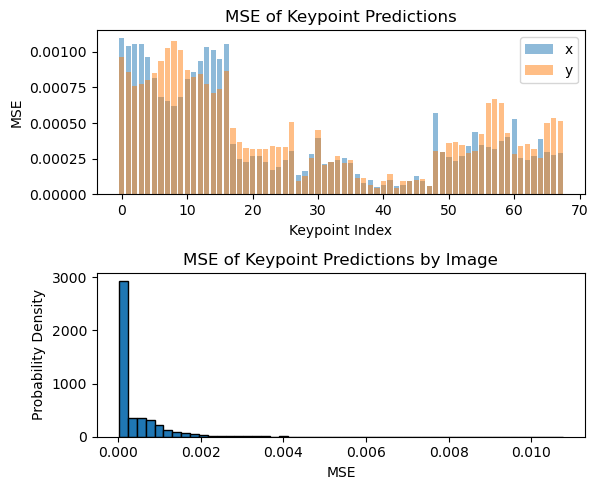

Images with highest error (MSE): ['04473.png', '04399.png', '04371.png', '03511.png', '04708.png']
MSE values: [0.01075668 0.00971404 0.00966332 0.00724152 0.00706182]

Images with lowest error (MSE): ['01255.png', '02742.png', '01356.png', '01566.png', '02683.png']
MSE values: [2.3113029e-05 2.3645789e-05 2.3719966e-05 2.5352063e-05 2.5629157e-05]

Correlation between x and y errors: -0.1548


In [24]:
mse_by_keypoint = np.mean(diff**2, axis=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))

ax1.bar(range(mse_by_keypoint.shape[1]), mse_by_keypoint[0], label="x", alpha=0.5)
ax1.bar(range(mse_by_keypoint.shape[1]), mse_by_keypoint[1], label="y", alpha=0.5)
ax1.set_title("MSE of Keypoint Predictions")
ax1.set_xlabel("Keypoint Index")
ax1.set_ylabel("MSE")
ax1.legend()

mse_by_im = np.mean(diff**2, axis=(1, 2))

ax2.hist(mse_by_im, bins=50, edgecolor="black", density=True)
ax2.set_title("MSE of Keypoint Predictions by Image")
ax2.set_xlabel("MSE")
ax2.set_ylabel("Probability Density")

plt.tight_layout()
plt.show()

worst_indices = np.argsort(-mse_by_im)[:5]
best_indices = np.argsort(mse_by_im)[:5]

print(f"Images with highest error (MSE): {[test_filenames[i] for i in worst_indices]}")
print(f"MSE values: {mse_by_im[worst_indices]}")
print(f"\nImages with lowest error (MSE): {[test_filenames[i] for i in best_indices]}")
print(f"MSE values: {mse_by_im[best_indices]}")

x_errors = np.abs(diff[0])
y_errors = np.abs(diff[1])
correlation = np.corrcoef(x_errors.flatten(), y_errors.flatten())[0, 1]
print(f"\nCorrelation between x and y errors: {correlation:.4f}")